In [1]:
# Install necessary libraries
!pip install pandas numpy seaborn matplotlib scikit-learn nltk wordcloud xgboost openpyxl


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load datasets
reviews_df = pd.read_csv('/content/Reviews_dataset.csv', on_bad_lines='skip', engine='python')
movie_df = pd.read_excel('/content/Movie_Dataset_Competition.xlsx')

# Preview the data
print("Reviews Dataset:")
print(reviews_df.head())
print("\nMovie Dataset:")
print(movie_df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Reviews Dataset:
   review_ID                                             review
0          1  One of the other reviewers has mentioned that ...
1          2  A wonderful little production. <br /><br />The...
2          3  I thought this was a wonderful way to spend ti...
3          4  Basically there's a family where a little boy ...
4          5  Petter Mattei's "Love in the Time of Money" is...

Movie Dataset:
                                         name rating   genre  year  \
0                                      Avatar  PG-13  Action  2009   
1                           Avengers: Endgame  PG-13  Action  2019   
2                                     Titanic  PG-13   Drama  1997   
3  Star Wars: Episode VII - The Force Awakens  PG-13  Action  2015   
4                      Avengers: Infinity War  PG-13  Action  2018   

                            released    votes       director  \
0  December 18, 2009 (United States)  1100000  James Cameron   
1     April 26, 2019 (United State

In [3]:
# Fill missing values
# Check if 'review_text' column exists before dropping NAs
if 'review_text' in reviews_df.columns:
    reviews_df.dropna(subset=['review_text'], inplace=True)  # Drop missing reviews
else:
    print("Warning: 'review_text' column not found in reviews_df.")

movie_df['budget'].fillna(movie_df['budget'].mean(), inplace=True)
movie_df['runtime'].fillna(movie_df['runtime'].median(), inplace=True)

# Convert categorical to string to avoid issues
movie_df['genre'] = movie_df['genre'].astype(str)
movie_df['director'] = movie_df['director'].astype(str)


<ipython-input-3-3582a8785911>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_df['budget'].fillna(movie_df['budget'].mean(), inplace=True)
<ipython-input-3-3582a8785911>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    words = text.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply text preprocessing
# Check if the 'review_text' column exists, otherwise use 'review'
reviews_df['cleaned_review'] = reviews_df['review_text'].apply(preprocess_text) \
    if 'review_text' in reviews_df.columns \
    else reviews_df['review'].apply(preprocess_text)  # Assuming 'review' as the alternative


In [5]:
# One-hot encoding for movie features
movie_df = pd.get_dummies(movie_df, columns=['genre', 'director'], drop_first=True)


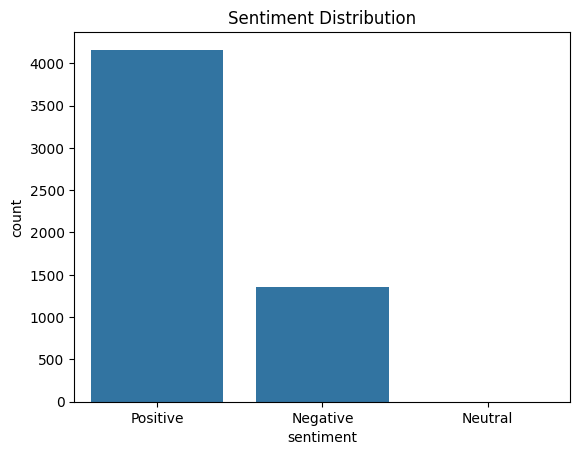

In [6]:
# Assuming the sentiment is present in 'review_text' and needs to be extracted
# Add a sentiment analysis step to generate the 'sentiment' column before plotting

# Example using TextBlob for sentiment analysis (install if not already installed)
!pip install textblob
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Check if 'review_text' column exists, otherwise use 'review' for sentiment analysis
if 'review_text' in reviews_df.columns:
    reviews_df['sentiment'] = reviews_df['review_text'].apply(get_sentiment)
else:
    # Assuming 'review' as the alternative column for review text
    reviews_df['sentiment'] = reviews_df['review'].apply(get_sentiment)

# Now proceed with the countplot
sns.countplot(x='sentiment', data=reviews_df)
plt.title('Sentiment Distribution')
plt.show()

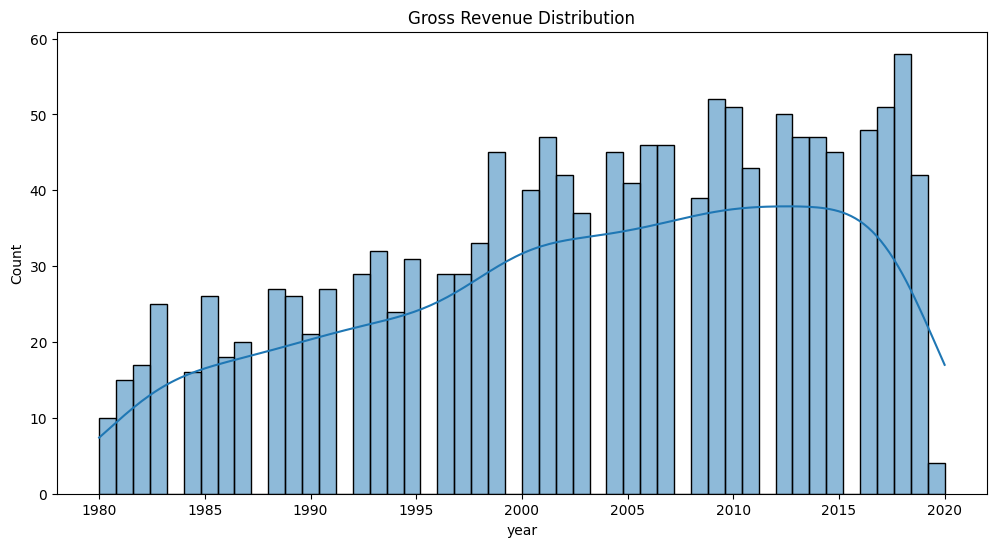

In [7]:
plt.figure(figsize=(12, 6))
# Check if 'gross' or 'Gross' column exists, if not, use available numerical column
gross_column = 'gross' if 'gross' in movie_df.columns else ('Gross' if 'Gross' in movie_df.columns else movie_df.select_dtypes(include=np.number).columns[0])
sns.histplot(movie_df[gross_column], bins=50, kde=True)
plt.title('Gross Revenue Distribution')
plt.show()

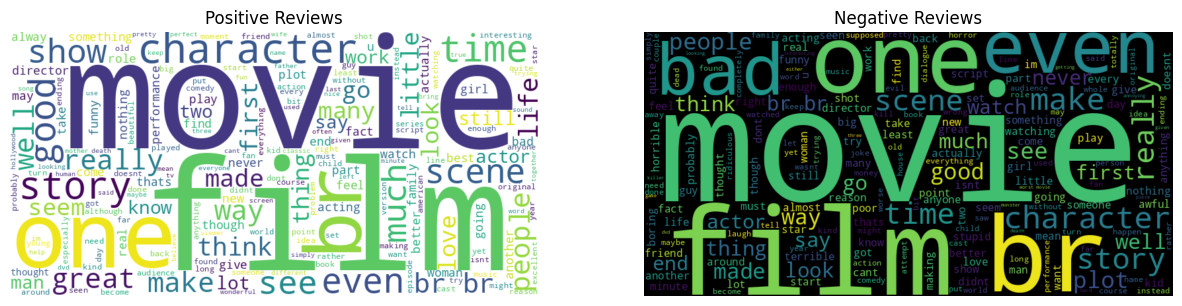

In [9]:
positive_reviews = ' '.join(reviews_df[reviews_df['sentiment'] == 'Positive']['cleaned_review'])
negative_reviews = ' '.join(reviews_df[reviews_df['sentiment'] == 'Negative']['cleaned_review'])

# Generate word clouds
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Positive reviews
# Check if positive_reviews is not empty before generating the word cloud
if positive_reviews:  # Check if positive_reviews is not empty
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
    ax[0].imshow(wordcloud_pos, interpolation='bilinear')
    ax[0].set_title('Positive Reviews')
    ax[0].axis('off')
else:
    ax[0].text(0.5, 0.5, 'No positive reviews to display', ha='center', va='center', fontsize=12)
    ax[0].axis('off')  # Hide axes if no data to display

# Negative reviews
# Check if negative_reviews is not empty before generating the word cloud
if negative_reviews:  # Check if negative_reviews is not empty
    wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
    ax[1].imshow(wordcloud_neg, interpolation='bilinear')
    ax[1].set_title('Negative Reviews')
    ax[1].axis('off')
else:
    ax[1].text(0.5, 0.5, 'No negative reviews to display', ha='center', va='center', fontsize=12)
    ax[1].axis('off')  # Hide axes if no data to display

plt.show()

In [10]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_reviews = vectorizer.fit_transform(reviews_df['cleaned_review'])
y_sentiment = reviews_df['sentiment']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reviews, y_sentiment, test_size=0.2, random_state=42)


In [12]:
# Logistic Regression Model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Sentiment Classification Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Sentiment Classification Results:
              precision    recall  f1-score   support

    Negative       0.85      0.51      0.64       272
    Positive       0.86      0.97      0.91       832

    accuracy                           0.86      1104
   macro avg       0.85      0.74      0.77      1104
weighted avg       0.86      0.86      0.84      1104

Confusion Matrix:
[[139 133]
 [ 25 807]]


In [20]:
# Select relevant features for prediction
features = ['budget', 'runtime'] + [col for col in movie_df.columns if col.startswith('genre') or col.startswith('director')]
X_revenue = movie_df[features]

# Check if 'gross' exists, if not, try 'gross_revenue', then fallback to a numerical column if neither exists
# For example, you can create a numerical representation of the rating or choose another numerical feature
if 'gross' in movie_df.columns:
    y_revenue = movie_df['gross']
elif 'gross_revenue' in movie_df.columns:
    y_revenue = movie_df['gross_revenue']
else:
    # Fallback to a numerical column or create one from the rating
    # For example, you can convert rating categories to numerical values (PG-13 -> 1, R -> 2, etc.)
    # or use a different numerical feature like 'runtime' if it's relevant for your task
    print("Warning: Neither 'gross' nor 'gross_revenue' columns found. Using 'runtime' as target variable.")
    y_revenue = movie_df['runtime'] # Replace with appropriate numerical column or feature engineering logic

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_revenue, y_revenue, test_size=0.2, random_state=42)

In [21]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_revenue = rf_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_revenue))
r2 = r2_score(y_test, y_pred_revenue)

print("\nBox Office Revenue Prediction:")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")



Box Office Revenue Prediction:
RMSE: 0.7252975191106547
R² Score: 0.9988169937600062


In [24]:
!pip install spacy
import spacy
from collections import Counter
from spacy import displacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Extract named entities from reviews
# Use 'review' column instead of 'review_text'
reviews_text = " ".join(reviews_df['review'].head(100))  # Sample of 100 reviews
doc = nlp(reviews_text)

# Display named entities
displacy.render(doc, style='ent', jupyter=True)

# Count and display most common entities
entities = [ent.text for ent in doc.ents]
entity_freq = Counter(entities).most_common(10)
print("\nMost Frequent Entities:", entity_freq)


Most Frequent Entities: [('one', 32), ('first', 30), ('Jimmy', 17), ('Hollywood', 14), ('two', 14), ('Mario', 11), ('Tom', 10), ('Hitchcock', 10), ('10', 9), ('three', 9)]


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming X_test and y_test are from the sentiment classification task
# X_test should be the TF-IDF vectorized reviews data
# y_test should be the sentiment labels

# Get probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]  # Use X_test instead of X_test_reviews

# Map sentiment labels to numerical values
y_test_numeric = y_test.map({'Positive': 1, 'Negative': 0, 'Neutral': 0}) # Use y_test instead of y_test_reviews

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_prob)
auc_score = roc_auc_score(y_test_numeric, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sentiment Classification')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 865 features, but LogisticRegression is expecting 5000 features as input.

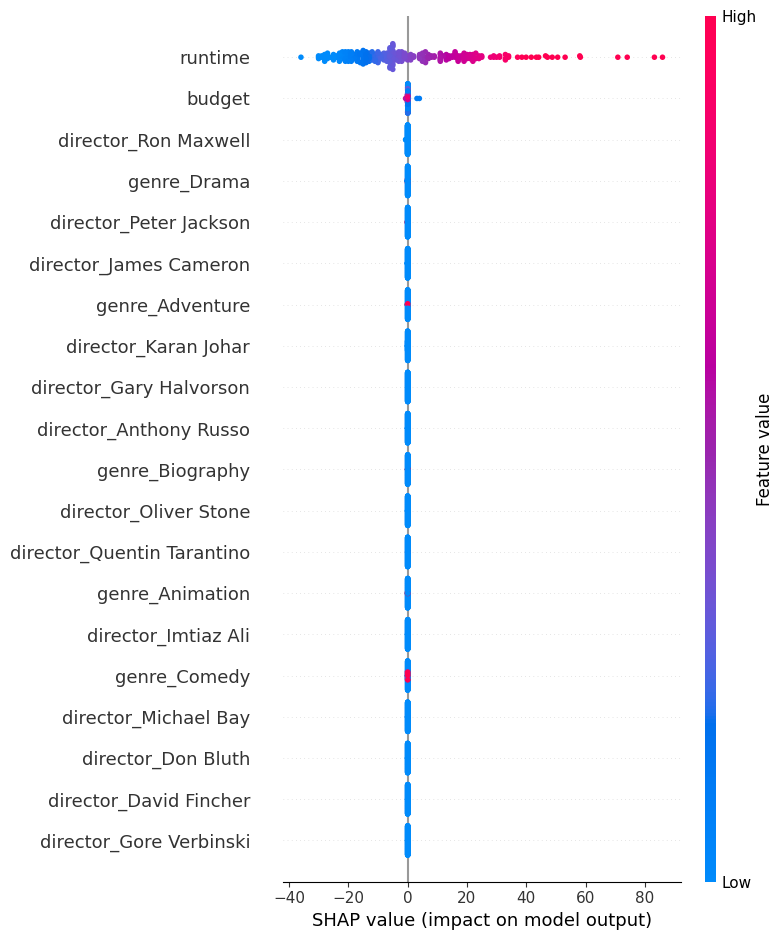

In [35]:
# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_numeric)

# Visualization
shap.summary_plot(shap_values, X_test_numeric)


In [36]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [37]:
!pip install gradio

import gradio as gr

def predict_sentiment(text):
    text_clean = preprocess_text(text)
    vector = vectorizer.transform([text_clean])
    sentiment = model.predict(vector)[0]
    return sentiment

# Create Gradio interface
iface = gr.Interface(fn=predict_sentiment,
                     inputs="text",
                     outputs="label",
                     title="Movie Review Sentiment Predictor")
iface.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e42476453b070f6a3f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/sp

In [38]:
import gradio as gr
import numpy as np

# Sentiment Prediction Function
def predict_sentiment(text):
    text_clean = preprocess_text(text)  # Preprocess the review
    vector = vectorizer.transform([text_clean])
    sentiment = model.predict(vector)[0]
    return sentiment

# Box Office Revenue Prediction Function
def predict_revenue(budget, runtime, genre, director):
    # Create input data frame
    input_data = pd.DataFrame([[budget, runtime]], columns=['budget', 'runtime'])

    # Encoding genre and director (dummy variables)
    for col in movie_df.columns:
        if col.startswith('genre_'):
            input_data[col] = 0
        if col.startswith('director_'):
            input_data[col] = 0

    genre_col = f'genre_{genre}' if f'genre_{genre}' in movie_df.columns else None
    director_col = f'director_{director}' if f'director_{director}' in movie_df.columns else None

    if genre_col:
        input_data[genre_col] = 1
    if director_col:
        input_data[director_col] = 1

    # Prediction
    revenue_pred = rf_model.predict(input_data)[0]
    return f"${revenue_pred:,.2f}"

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# 🎬 Movie Insights and Revenue Predictor")

    with gr.Tab("Sentiment Analysis"):
        sentiment_input = gr.Textbox(label="Enter a movie review")
        sentiment_output = gr.Label(label="Predicted Sentiment")
        gr.Interface(fn=predict_sentiment, inputs=sentiment_input, outputs=sentiment_output).launch()

    with gr.Tab("Box Office Revenue Prediction"):
        budget = gr.Number(label="Budget (in millions)", value=50)
        runtime = gr.Number(label="Runtime (in minutes)", value=120)
        genre = gr.Dropdown(choices=['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Fantasy'], label="Genre")
        director = gr.Dropdown(choices=['Christopher Nolan', 'Judd Apatow', 'James Cameron'], label="Director")
        revenue_output = gr.Label(label="Predicted Box Office Revenue")

        gr.Interface(
            fn=predict_revenue,
            inputs=[budget, runtime, genre, director],
            outputs=revenue_output
        ).launch()

# Run the Gradio app
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a9c43e4bb01e794b2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9150e8ac980d3b2353.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cd4963cb1180d9611a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
